In [5]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper

from IPython.display import Image 

from sklearn.tree import export_graphviz
from six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# We'll also import some helper functions that will be useful later on.
#from util import load_data, cindex
#from public_tests import *

In [6]:
data = pd.read_csv('../data/benchmark_features.csv')
print('Shape of data:', data.shape)

# set the features and labels
X, y = data.drop(columns=['dropout']), data['dropout']

Shape of data: (1321, 149)


In [7]:
# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.15, random_state=42)

# check the shape of the train, validation, and test sets
print(X_train.shape, X_val.shape, X_test.shape)


(953, 148) (169, 148) (199, 148)


In [ ]:
X_train.iloc[10, :]

In [8]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Now we will evaluate the model using the C-Index


In [9]:
y_train_preds = dt.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.7273045671056318


### Update Hyperparams

In [10]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    ### START CODE HERE ###
    
    'criterion': 'gini', 
    'max_depth': 3, 
    'max_features': None, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2
    
    ### END CODE HERE ###
}

In [11]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train, y_train)

y_train_preds = dt_reg.predict_proba(X_train)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.9145269302392207
Val C-Index (expected > 0.6): 0.8853320257775287


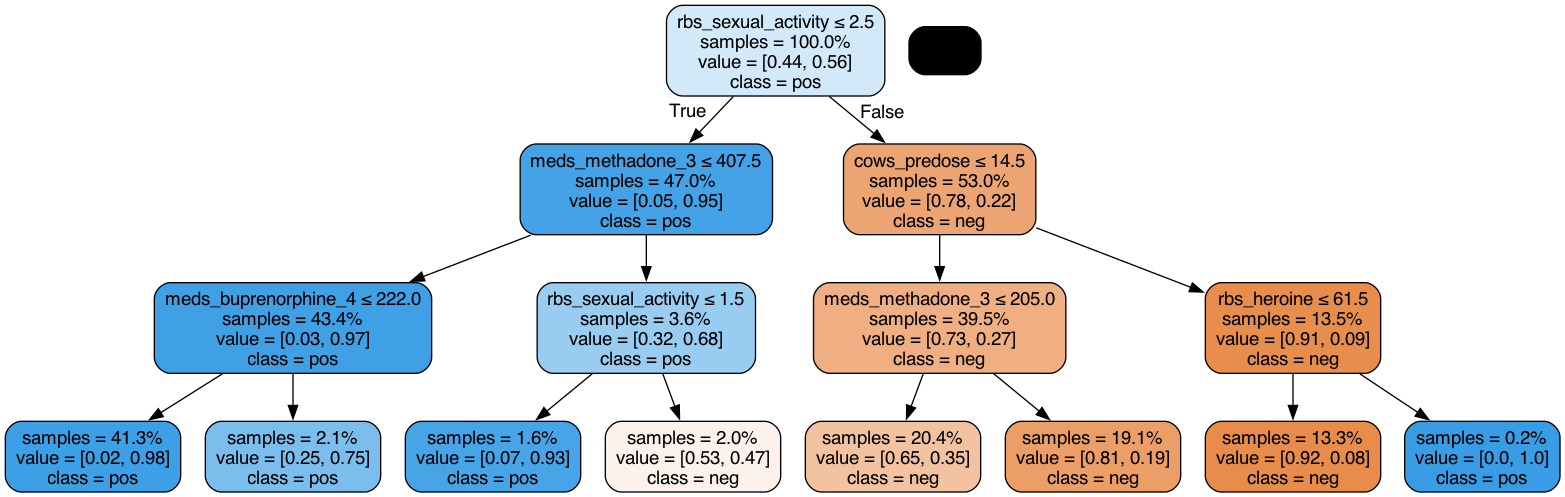

In [12]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train, y_train)

In [ ]:
y_train_rf_preds = rf.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {helper.cindex(y_val.values, y_val_rf_preds)}")

In [ ]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # store results for plotting
    results = []

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)
        
        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)
        
        # compute cindex for predictions
        estimator_score = helper.cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # store results 
        results.append([param_dict, estimator_score])

        # if new high score, update high score, best estimator
        # and best params 
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams, results

In [ ]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters 
    hyperparams = {
        
        ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [100, 200, 300],

        # the maximum depth of trees in the forest (int)
        
        'max_depth': [3, 5, 7],
        
        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [0.01, 0.05, 0.1],

        ### END CODE HERE ###
    }

    
    fixed_hyperparams = {
        'random_state': 10,
    }
    
    rf = RandomForestClassifier

    best_rf, best_hyperparams, results = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    
    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {helper.cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {helper.cindex(y_val_dropped, y_val_best)}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams, results

In [ ]:
best_rf, best_hp, results = random_forest_grid_search(X_train, y_train, X_val, y_val)

In [ ]:
# plot the training logs from the results
results_df = pd.DataFrame(results, columns=['hyperparameters', 'c-index'])
results_df['n_estimators'] = results_df['hyperparameters'].apply(lambda x: x['n_estimators'])
results_df['max_depth'] = results_df['hyperparameters'].apply(lambda x: x['max_depth'])
results_df['min_samples_leaf'] = results_df['hyperparameters'].apply(lambda x: x['min_samples_leaf'])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(data=results_df, x='n_estimators', y='c-index', ax=axs[0])
sns.scatterplot(data=results_df, x='max_depth', y='c-index', ax=axs[1])
sns.scatterplot(data=results_df, x='min_samples_leaf', y='c-index', ax=axs[2])
plt.show();



In [ ]:
results_df

In [ ]:
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {helper.cindex(y_test.values, y_test_best)}")

In [ ]:
# Define ranges for the random forest hyperparameter search 
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

    # how many trees should be in the forest (int)
    'n_estimators': [100, 200, 300],

    # the maximum depth of trees in the forest (int)
    'max_depth': [3, 5, 7],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [0.01, 0.5]
    ### END CODE HERE ###
}

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

best_rf, best_hp , results= holdout_grid_search(rf, X_train, y_train,
                                                                     X_val, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = best_rf.predict_proba(X_train)[:, 1]
print(f"- Train C-Index: {helper.cindex(y_train, y_train_best):.4f}")

y_val_best = best_rf.predict_proba(X_val)[:, 1]
print(f"- Val C-Index: {helper.cindex(y_val, y_val_best):.4f}")

y_test_imp = best_rf.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {helper.cindex(y_test, y_test_imp):.4f}")

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Plot confusion matrix using heatmap.
    
    Args:
    y_true: true labels
    y_pred: predicted labels
    labels: class labels
    '''
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=False)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()

In [ ]:
plot_confusion_matrix(y_test, y_test_imp > 0.5, ['No Dropout', 'Dropout']);

### Explanations: SHAP